2. Предобработка
    1. Исследовать и обработать пропуски в данных, если таковые имеются
    2. Нормализовать данные, если потребуется
    3. Проверить наличие константных и скорелированных фичей
    4. Обработать категориальные фичи для моделей, которым это требуется, попробовать разные способы
    5. Изучить выбросы

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import os
from pathlib import Path
import config 

In [26]:
train = pd.read_csv(config.CONFIG['paths']['train'])
test = pd.read_csv(config.CONFIG['paths']['test'])

# 1. Обработка пропусков

In [27]:
df = train.copy()

missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
missing_df = missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False)
print(missing_df)

          Missing    Percent
Cabin         687  77.104377
Age           177  19.865320
Embarked        2   0.224467


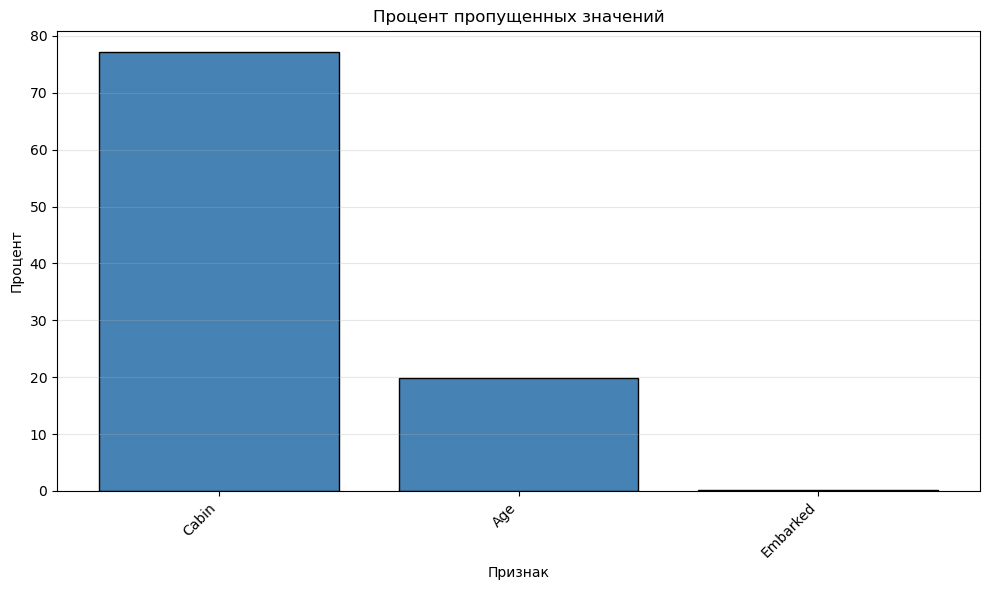

In [28]:
plt.figure(figsize=(10, 6))
plt.bar(missing_df.index, missing_df['Percent'], color='steelblue', edgecolor='black')
plt.title('Процент пропущенных значений')
plt.ylabel('Процент')
plt.xlabel('Признак')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
if 'Cabin' in df.columns:
    df = df.drop(columns=['Cabin'])

median_age = df['Age'].median()
df['Age'] = df['Age'].fillna(median_age)

mode_embarked = df['Embarked'].mode()[0]
df['Embarked'] = df['Embarked'].fillna(mode_embarked)

In [30]:
df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

Итог такой что удалили Cabin из за слишком много пропусков, пропуски в Age заполнили медианой, в Embarked убрали 2 пропуска заполнили модой

# 2. Нормализация данных

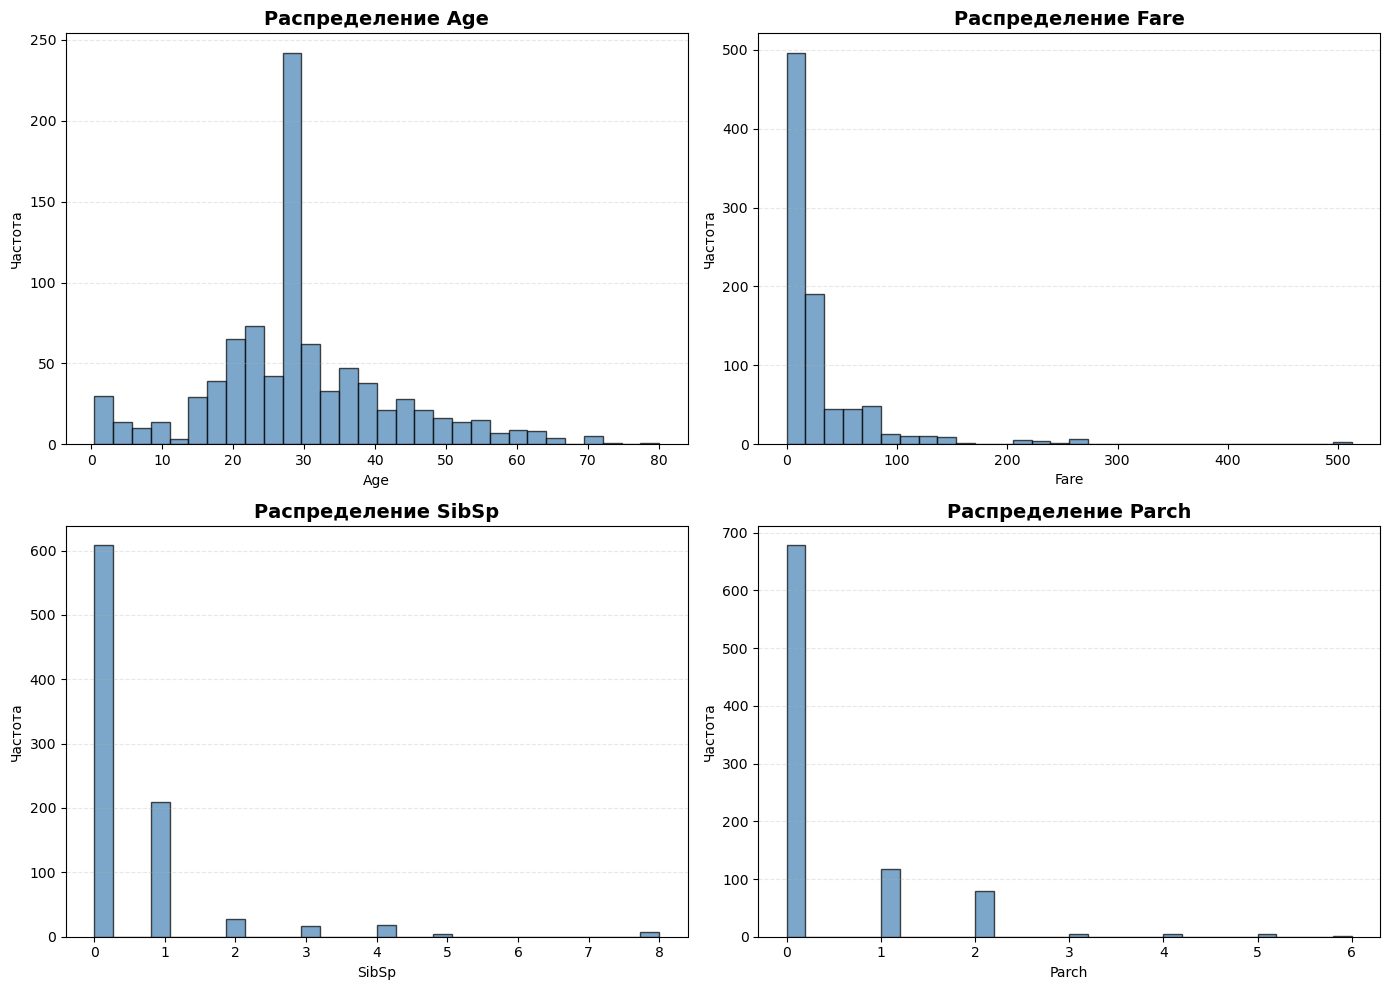

              Age        Fare       SibSp       Parch
count  891.000000  891.000000  891.000000  891.000000
mean    29.361582   32.204208    0.523008    0.381594
std     13.019697   49.693429    1.102743    0.806057
min      0.420000    0.000000    0.000000    0.000000
25%     22.000000    7.910400    0.000000    0.000000
50%     28.000000   14.454200    0.000000    0.000000
75%     35.000000   31.000000    1.000000    0.000000
max     80.000000  512.329200    8.000000    6.000000


In [31]:
numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch']
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, col in enumerate(numeric_cols):
    row = idx // 2
    col_pos = idx % 2
    ax = axes[row, col_pos]
    
    data = df[col].dropna()
    
    ax.hist(
        data,
        bins=30,
        edgecolor='black',
        alpha=0.7,
        color='steelblue'
    )
    
    ax.set_title(f'Распределение {col}', fontsize=14, fontweight='bold')
    ax.set_xlabel(col)
    ax.set_ylabel('Частота')
    ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print(df[numeric_cols].describe())

Видно что Fare скошен поэтому используем логарифмирование и age и fare нужно мастштабирование

In [32]:
fare_skew_before = ((df['Fare'] - df['Fare'].mean())**3).mean() / (df['Fare'].std()**3)
print(fare_skew_before)

df['Fare_log'] = np.log1p(df['Fare'])

4.771209669373586


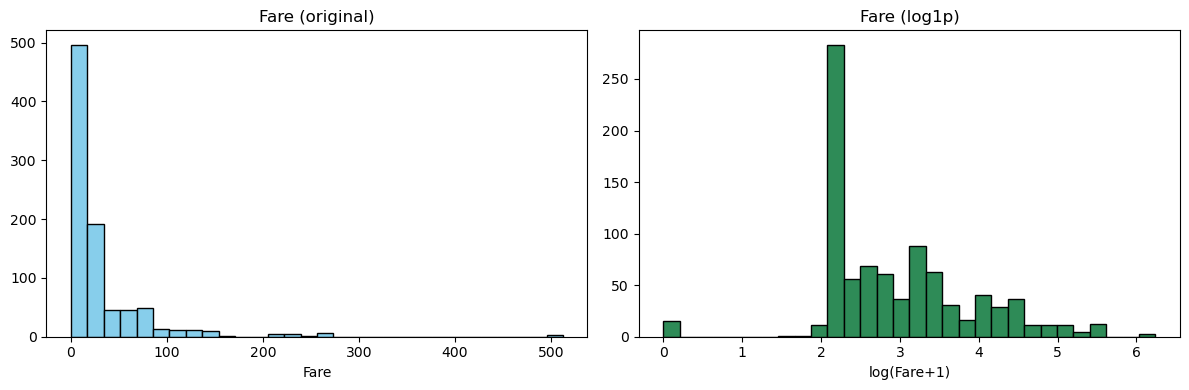

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(df['Fare'].dropna(), bins=30, color='skyblue', edgecolor='black')
axes[0].set_title(f'Fare (original)')
axes[0].set_xlabel('Fare')
axes[1].hist(df['Fare_log'].dropna(), bins=30, color='seagreen', edgecolor='black')
axes[1].set_title(f'Fare (log1p)')
axes[1].set_xlabel('log(Fare+1)')
plt.tight_layout()
plt.show()

In [34]:
df['Fare'] = df['Fare_log']
df = df.drop(columns=['Fare_log'])
fare_skew_after = ((df['Fare'] - df['Fare'].mean())**3).mean() / (df['Fare'].std()**3)
print(fare_skew_after)

0.39359928051115095


In [35]:
for col in ['Age', 'Fare']:
    mean_val = df[col].mean()
    std_val = df[col].std()
    df[col] = (df[col] - mean_val) / std_val


после нормализации


In [36]:
df[['Age', 'Fare', 'SibSp', 'Parch']].describe().loc[['mean', 'std']]

,Age,Fare,SibSp,Parch
mean,2.232906e-16,-1.874046e-16,0.523008,0.381594
std,1.000000e+00,1.000000e+00,1.102743,0.806057


# 3. Константные и скоррелированые фичи

Константный признак — это колонка, где все значения одинаковы.
Скоррелированные признаки — это две или более колонки, которые сильно линейно связаны друг с другом.


In [37]:
constant_cols = [col for col in df.columns if df[col].nunique() == 1 and col not in ['PassengerId', 'Survived']]

if constant_cols:
    print(f"константные признаки {constant_cols}")
    df = df.drop(columns=constant_cols)
else:
    print("Констант нет")

Констант нет


In [38]:
def pearson_corr(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    numerator = ((x - x_mean) * (y - y_mean)).sum()
    denominator = np.sqrt(((x - x_mean)**2).sum() * ((y - y_mean)**2).sum())
    return numerator / denominator if denominator != 0 else 0

numeric_df = df.select_dtypes(include=[np.number]).drop(columns=['Survived', 'PassengerId'], errors='ignore')
corr_cols = numeric_df.columns.tolist()

corr_matrix = pd.DataFrame(index=corr_cols, columns=corr_cols)
for i, col1 in enumerate(corr_cols):
    for j, col2 in enumerate(corr_cols):
        if i == j:
            corr_matrix.loc[col1, col2] = 1.0
        elif i > j:
            corr_matrix.loc[col1, col2] = corr_matrix.loc[col2, col1]
        else:
            corr_matrix.loc[col1, col2] = pearson_corr(numeric_df[col1], numeric_df[col2])

corr_matrix = corr_matrix.astype(float).abs()


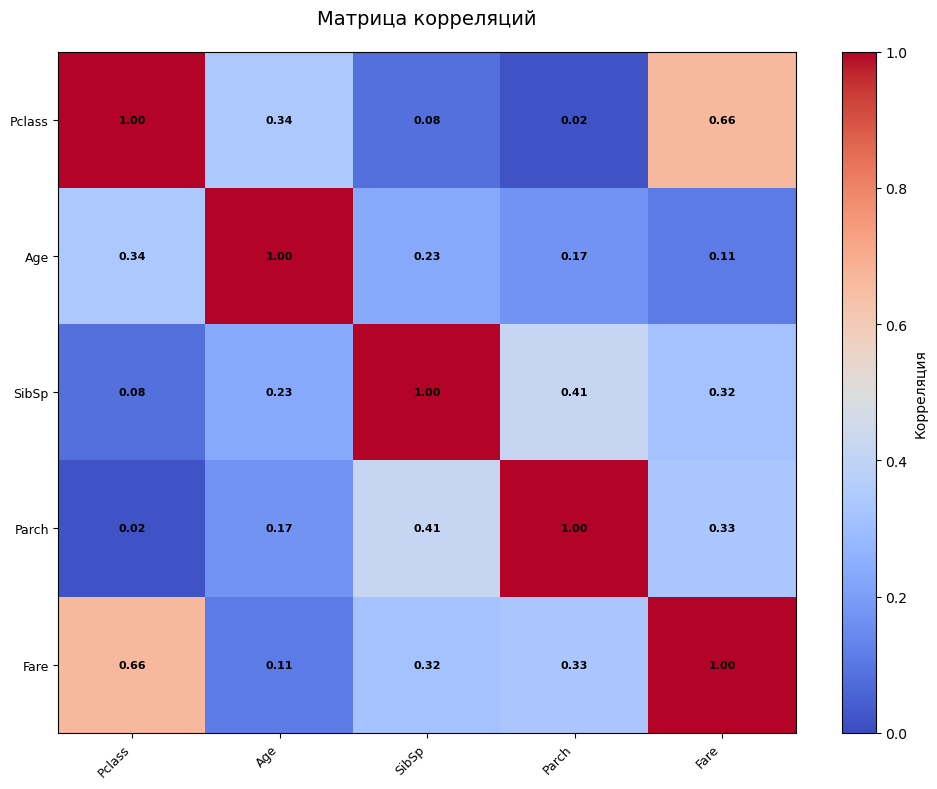

In [39]:
plt.figure(figsize=(10, 8))

im = plt.imshow(corr_matrix.values, cmap='coolwarm', aspect='auto', vmin=0, vmax=1)
plt.colorbar(im, label='Корреляция')

plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha='right', fontsize=9)
plt.yticks(range(len(corr_cols)), corr_cols, fontsize=9)

for i in range(len(corr_cols)):
    for j in range(len(corr_cols)):
        val = corr_matrix.iloc[i, j]
        plt.text(j, i, f'{val:.2f}', ha='center', va='center', 
                fontsize=8, fontweight='bold')

plt.title('Матрица корреляций', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# 4. Обработка категориальных фич

In [40]:
cat_cols = config.CONFIG['preprocessing']['categorical_cols']
encode_method = config.CONFIG['preprocessing']['encode_method']

print(f"Категориальные признаки: {cat_cols}")
print(f"Метод кодирования: {encode_method}")

encoders = {}

cat_cols = [col for col in cat_cols if col in df.columns]

if encode_method == 'label':
    from sklearn.preprocessing import LabelEncoder
    
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        encoders[f'{col}_label_encoder'] = le
        
        print(f"{col}: {len(le.classes_)} ")
        print(f"  Маппинг: {dict(zip(le.classes_, range(len(le.classes_))))}")
    
    print(f"\nИтоговые уникальные значения:")
    for col in cat_cols:
        print(f"  {col}: {sorted(df[col].unique())}")

elif encode_method == 'onehot':
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_data = ohe.fit_transform(df[cat_cols])
    
    feature_names = []
    for i, col in enumerate(cat_cols):
        for category in ohe.categories_[i]:
            feature_names.append(f'{col}_{category}')
    
    encoded_df = pd.DataFrame(
        encoded_data,
        columns=feature_names,
        index=df.index
    )
    
    print(f"{len(feature_names)} новые колонки:")
    print(f" {feature_names}")
    
    df = pd.concat([df, encoded_df], axis=1)
    
    df = df.drop(columns=cat_cols)
    
    encoders['onehot_encoder'] = {
        'encoder': ohe,
        'original_columns': cat_cols,
        'new_columns': feature_names
    }
    
    print(f"Оригинальные колонки удалены: {cat_cols}")
    print(f"DataFrame shape: {df.shape}")

else:
    raise ValueError(f"Неизвестный метод кодирования: {encode_method}. Используйте 'label' или 'onehot'")

print(df.shape)
print(f"Колонки: {df.columns.tolist()}")

Категориальные признаки: ['Sex', 'Embarked', 'Pclass']
Метод кодирования: label
Sex: 2 
  Маппинг: {'female': 0, 'male': 1}
Embarked: 3 
  Маппинг: {'C': 0, 'Q': 1, 'S': 2}
Pclass: 3 
  Маппинг: {'1': 0, '2': 1, '3': 2}

Итоговые уникальные значения:
  Sex: [0, 1]
  Embarked: [0, 1, 2]
  Pclass: [0, 1, 2]
(891, 11)
Колонки: ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


# 5. Выбросы

In [41]:
def find_outliers_iqr(series):
    Q1 = np.percentile(series.dropna(), 25)
    Q3 = np.percentile(series.dropna(), 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return outliers, lower, upper

In [42]:
numeric_cols = ['Age', 'Fare', 'SibSp', 'Parch']

for col in numeric_cols:
    if col in df.columns:
        outliers, low, high = find_outliers_iqr(df[col])
        pct = len(outliers) / len(df) * 100
        print(f"{col}: {len(outliers)} выбросов ({pct:.1f}%), границы: [{low:.2f}, {high:.2f}]")

Age: 66 выбросов (7.4%), границы: [-2.06, 1.93]
Fare: 31 выбросов (3.5%), границы: [-2.78, 2.50]
SibSp: 46 выбросов (5.2%), границы: [-1.50, 2.50]
Parch: 213 выбросов (23.9%), границы: [0.00, 0.00]


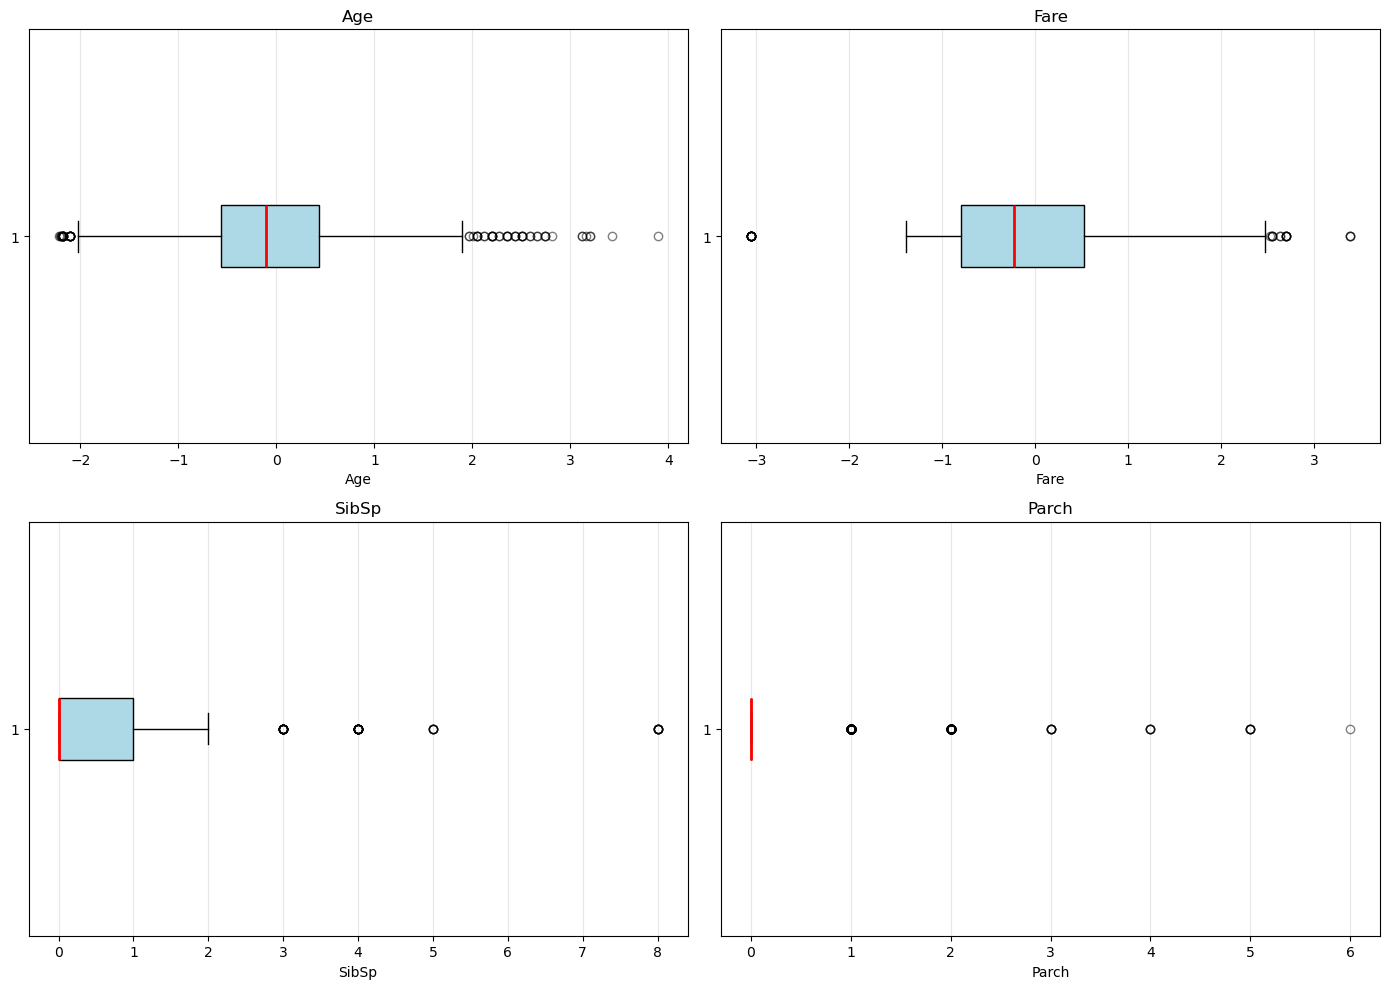

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, col in enumerate(numeric_cols):
    if col not in df.columns:
        continue
    row = idx // 2
    col_pos = idx % 2
    data = df[col].dropna()
    
    # Boxplot через matplotlib
    axes[row, col_pos].boxplot([data], vert=False, patch_artist=True,
                                boxprops=dict(facecolor='lightblue', color='black'),
                                medianprops=dict(color='red', linewidth=2),
                                whiskerprops=dict(color='black'),
                                capprops=dict(color='black'),
                                flierprops=dict(marker='o', color='gray', alpha=0.5))
    axes[row, col_pos].set_title(f'{col}')
    axes[row, col_pos].set_xlabel(col)
    axes[row, col_pos].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()


In [44]:
fare_outliers, fare_low, fare_high = find_outliers_iqr(df['Fare'])

print(f"Нижняя граница: {fare_low:.2f}")
print(f"Верхняя граница: {fare_high:.2f}")
print(f"Выбросов: {len(fare_outliers)} из {len(df)} ({len(fare_outliers)/len(df)*100:.1f}%)")

if len(fare_outliers) > 0:
    print(f"\nПримеры выбросов в Fare:")
    print(df.loc[fare_outliers.index[:5], ['Fare', 'Pclass', 'Sex', 'Survived']])

Нижняя граница: -2.78
Верхняя граница: 2.50
Выбросов: 31 из 891 (3.5%)

Примеры выбросов в Fare:
         Fare  Pclass  Sex  Survived
27   2.697186       0    1         0
88   2.697186       0    0         1
118  2.634833       0    1         0
179 -3.056861       2    1         0
258  3.383393       0    0         1


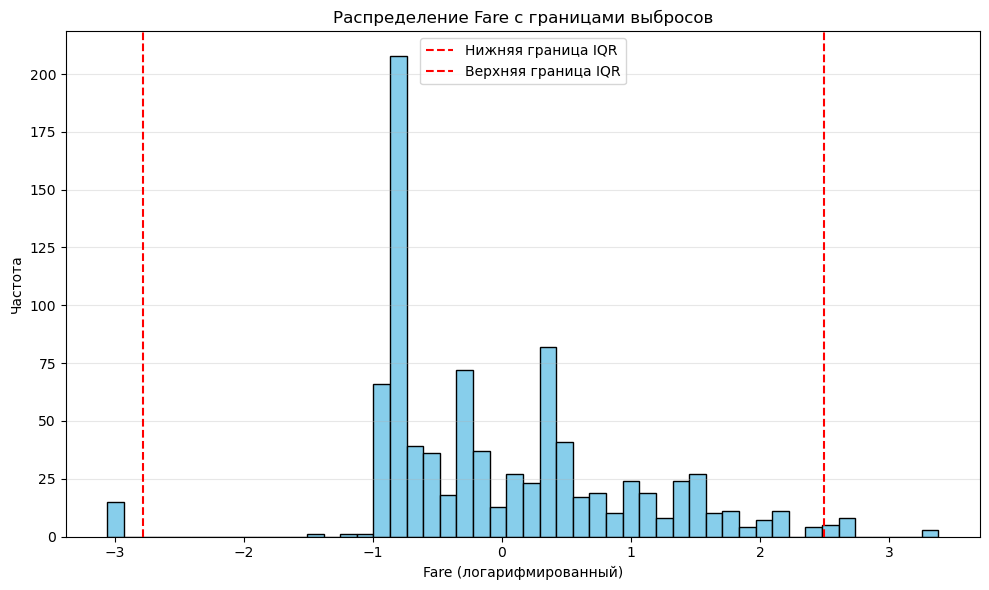

In [45]:
plt.figure(figsize=(10, 6))
plt.hist(df['Fare'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.axvline(fare_low, color='red', linestyle='--', label='Нижняя граница IQR')
plt.axvline(fare_high, color='red', linestyle='--', label='Верхняя граница IQR')
plt.title('Распределение Fare с границами выбросов')
plt.xlabel('Fare (логарифмированный)')
plt.ylabel('Частота')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# сохранение данных

In [46]:
from datetime import datetime
import json

checkpoint_dir = config.CONFIG['paths']['checkpoint_dir']
os.makedirs(checkpoint_dir, exist_ok=True)


preprocessed_path = config.CONFIG['paths']['train_preprocessed']
df.to_csv(preprocessed_path, index=False)
print(f"Датасет сохранён: {preprocessed_path}")
print(f"Размер: {df.shape}")
print(f"Размер файла: {os.path.getsize(preprocessed_path) / 1024:.2f} KB")


preprocessing_metadata = {
    'encoders': {},
    
    'scaler_params': {
        'Age': {
            'mean': float(df['Age'].mean()),
            'std': float(df['Age'].std())
        },
        'Fare': {
            'mean': float(df['Fare'].mean()),
            'std': float(df['Fare'].std())
        }
    },
    
    'dropped_columns': ['Cabin', 'Fare_log'],  
    
    'final_columns': df.columns.tolist(),
    
    'target_column': 'Survived',
    'id_column': 'PassengerId',
    
    'preprocessing_config': {
        'fill_age_with': config.CONFIG['preprocessing']['fill_age_with'],
        'fill_embarked_with': config.CONFIG['preprocessing']['fill_embarked_with'],
        'drop_cabin': config.CONFIG['preprocessing']['drop_cabin'],
        'log_fare': config.CONFIG['preprocessing']['log_fare'],
        'encode_method': config.CONFIG['preprocessing']['encode_method'],
        'categorical_cols': config.CONFIG['preprocessing']['categorical_cols']
    },
    
    'dataset_info': {
        'original_shape': train.shape,
        'preprocessed_shape': df.shape,
        'missing_values': int(df.isnull().sum().sum()),
        'duplicate_rows': int(df.duplicated().sum()),
        'numeric_columns': df.select_dtypes(include=[np.number]).columns.tolist(),
        'categorical_columns': df.select_dtypes(include=['object']).columns.tolist()
    }
}


if config.CONFIG['preprocessing']['encode_method'] == 'label':
    for col in config.CONFIG['preprocessing']['categorical_cols']:
        if col in df.columns:
            unique_vals = sorted(df[col].unique())
            preprocessing_metadata['encoders'][col] = {
                'type': 'label_encoder',
                'mapping': {str(val): int(idx) for idx, val in enumerate(unique_vals)},
                'unique_values': [str(v) for v in unique_vals]
            }
elif config.CONFIG['preprocessing']['encode_method'] == 'onehot':

    preprocessing_metadata['encoders']['onehot'] = {
        'type': 'onehot_encoder',
        'original_columns': config.CONFIG['preprocessing']['categorical_cols'],
        'note': 'One-Hot колонки уже созданы в датасете'
    }


metadata_json_path = config.CONFIG['paths']['metadata_json']
with open(metadata_json_path, 'w', encoding='utf-8') as f:
    json.dump(preprocessing_metadata, f, indent=2, ensure_ascii=False)
print(f"\nМетаданные сохранены (JSON): {metadata_json_path}")


metadata_pickle_path = config.CONFIG['paths']['metadata_pickle']
with open(metadata_pickle_path, 'wb') as f:
    pickle.dump(preprocessing_metadata, f)
print(f"Метаданные сохранены (PKL): {metadata_pickle_path}")


encoders_to_save = {}

if 'encoders' in locals() and isinstance(locals()['encoders'], dict):
    encoders_to_save = locals()['encoders']
    encoders_path = checkpoint_dir / 'encoders.pkl'
    with open(encoders_path, 'wb') as f:
        pickle.dump(encoders_to_save, f)
    print(f"Энкодеры сохранены: {encoders_path}")
    print(f"Сохранённые энкодеры: {list(encoders_to_save.keys())}")
else:
    print(f"\nЭнкодеры не найдены в локальной области видимости")
    print(f"  Информация о маппинге сохранена в метаданных (JSON/PKL)")
    print(f"  Для инференса можно воссоздать энкодеры из метаданных")


print(f"Обработанный датасет: {preprocessed_path}")
print(f"Метаданные (JSON): {metadata_json_path}")
print(f"Метаданные (PKL): {metadata_pickle_path}")
if encoders_to_save:
    print(f"Энкодеры: {checkpoint_dir / 'encoders.pkl'}")

Датасет сохранён: C:\newTry2\classicMLpractice\ProjectKaggle\checkpoints\train_preprocessed.csv
Размер: (891, 11)
Размер файла: 82.07 KB

Метаданные сохранены (JSON): C:\newTry2\classicMLpractice\ProjectKaggle\checkpoints\preprocessing_metadata.json
Метаданные сохранены (PKL): C:\newTry2\classicMLpractice\ProjectKaggle\checkpoints\preprocessing_metadata.pkl
Энкодеры сохранены: C:\newTry2\classicMLpractice\ProjectKaggle\checkpoints\encoders.pkl
Сохранённые энкодеры: ['Sex_label_encoder', 'Embarked_label_encoder', 'Pclass_label_encoder']
Обработанный датасет: C:\newTry2\classicMLpractice\ProjectKaggle\checkpoints\train_preprocessed.csv
Метаданные (JSON): C:\newTry2\classicMLpractice\ProjectKaggle\checkpoints\preprocessing_metadata.json
Метаданные (PKL): C:\newTry2\classicMLpractice\ProjectKaggle\checkpoints\preprocessing_metadata.pkl
Энкодеры: C:\newTry2\classicMLpractice\ProjectKaggle\checkpoints\encoders.pkl
